In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout #Riga interessante
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16,InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

Creazione del **Train**, del **Validation set** e **Test set** dallo stream delle immagini contenute nelle rispettive cartelle.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.1, horizontal_flip= True)
valid_datagen= ImageDataGenerator(rescale=1./255)
image_size = 224

train_set = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/Landmark Recognition/data/train',
        target_size=(image_size, image_size),
        batch_size=10,
        class_mode='categorical'
        )

valid_set = valid_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/Landmark Recognition/data/val',
        target_size=(image_size, image_size),
        batch_size=10,
        class_mode='categorical'
        ) 

test_set= valid_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/Landmark Recognition/data/test', 
        target_size=(image_size, image_size), 
        batch_size=1, 
        class_mode='categorical', 
        shuffle=False
        )

Found 11387 images belonging to 100 classes.
Found 1380 images belonging to 100 classes.
Found 1515 images belonging to 100 classes.


# CREAZIONE DELLA **XCEPTION**







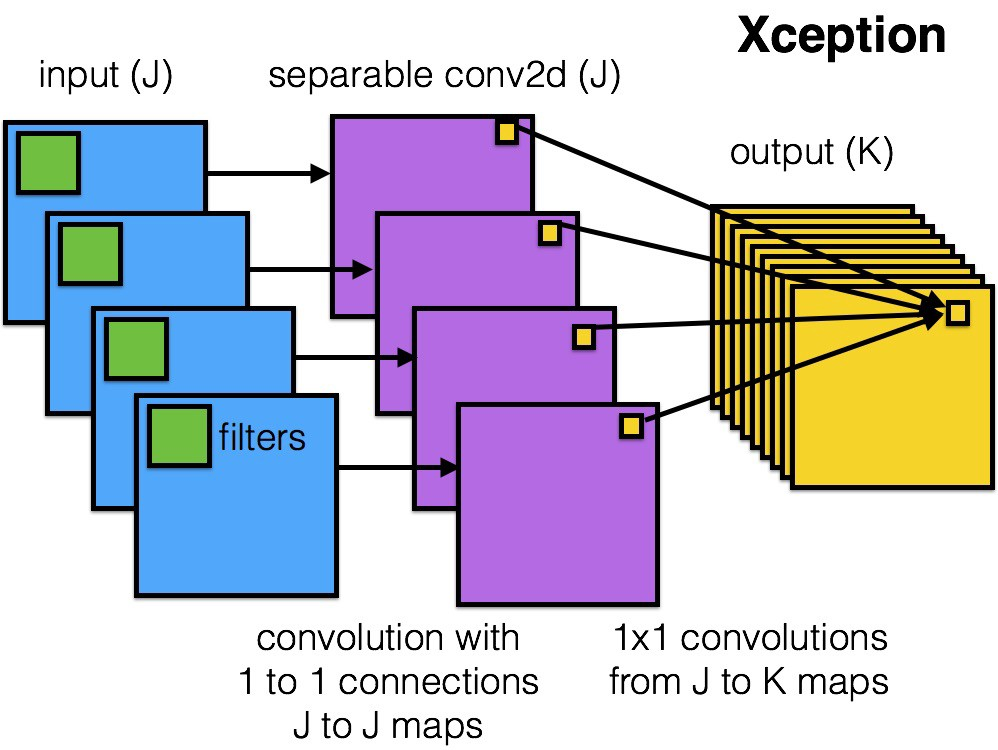

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Input
from tensorflow.keras.models import Model

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Istanziamento della **Xception**

Abbiamo deciso di utilizzare il *Transfer Learning*: questa tecnica consente di riutilizzare gran parte dei parametri di una rete neurale già addestrata in precedenza su un problema simile a quello che dobbiamo risolvere, soffermandoci sull’addestramento solo degli ultimi layer che sono solitamente quelli dedicati alla classificazione e/o alla regressione delle feature ottenute con i layer precedenti

Keras offre la possibilità di importare modelli già pre-addestrati sul dataset di Imagenet, permettendo di utilizzarli per nuovi task di Image Classification.

In [ ]:
base_model = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3))

# create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)


83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Una volta importata la rete, abbiamo "*congelato*" i layers, fino al 105-esimo strato.



In [ ]:
len(model.layers)

135

In [ ]:
for layer in model.layers[:-30]:
    layer.trainable = False

### Compilazione del modello

Abbiamo compilato il modello utilizzando come **optimizer** lo **Stochastic Gradient Descent**.

Inoltre come metrica per valutare la Loss, come consuetudine, abbiamo utilizzato l'**accuracy**.

In [ ]:
from tensorflow.python.keras import optimizers

sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
step_size_train=train_set.n//train_set.batch_size
step_size_valid=valid_set.n//valid_set.batch_size

## Addestramento del modello

Per il fit abbiamo fissato il numero di *epoche* a 30.



In [ ]:
model.fit(x=train_set, steps_per_epoch=step_size_train, validation_data= valid_set, validation_steps=step_size_valid, epochs=30)


Epoch 1/30
1138/1138 [==============================] - 3969s 3s/step - loss: 2.0461 - accuracy: 0.5444 - val_loss: 0.2825 - val_accuracy: 0.9246
Epoch 2/30
1138/1138 [==============================] - 493s 433ms/step - loss: 0.1985 - accuracy: 0.9436 - val_loss: 0.2979 - val_accuracy: 0.9333
Epoch 3/30
1138/1138 [==============================] - 484s 425ms/step - loss: 0.0770 - accuracy: 0.9780 - val_loss: 0.1667 - val_accuracy: 0.9609
Epoch 4/30
1138/1138 [==============================] - 476s 419ms/step - loss: 0.0541 - accuracy: 0.9841 - val_loss: 0.1605 - val_accuracy: 0.9630
Epoch 5/30
1138/1138 [==============================] - 487s 428ms/step - loss: 0.0305 - accuracy: 0.9928 - val_loss: 0.1487 - val_accuracy: 0.9630
Epoch 6/30
1138/1138 [==============================] - 502s 441ms/step - loss: 0.0338 - accuracy: 0.9888 - val_loss: 0.1317 - val_accuracy: 0.9710
Epoch 7/30
1138/1138 [==============================] - 503s 442ms/step - loss: 0.0286 - accuracy: 0.9916 - val_lo

In [ ]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)
print(test_steps_per_epoch)

1515


## Valutazione del modello
Valutiamo le prestazioni del modello attraverso le immagini contenute nel Test set.

In [ ]:
predictions = model.predict(x=test_set, steps=test_steps_per_epoch, verbose=2)

1515/1515 - 514s


Utilizziamo la **Classification Report** per mostrare le percentuali corrispondenti alla *Precision*, alla *Recall* e alla *F1-score*.

Infine ci permette di ottenere l'**accuracy** ottenuta dal modello sul Test Set.

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

       10018       1.00      1.00      1.00        11
       10094       1.00      1.00      1.00        16
       10602       1.00      0.93      0.97        15
       11300       1.00      1.00      1.00        16
       11378       1.00      1.00      1.00        16
       11491       1.00      1.00      1.00        14
       11499       1.00      1.00      1.00        16
       11513       1.00      1.00      1.00        13
        1168       1.00      0.94      0.97        16
       11716       1.00      1.00      1.00        12
       11719       1.00      1.00      1.00        17
       11750       0.94      1.00      0.97        17
       11849       0.88      1.00      0.94        15
       11967       1.00      1.00      1.00        15
       12181       1.00      1.00      1.00        14
       12204       1.00      1.00      1.00        17
       12360       0.94      0.94      0.94        16
       12481       0.94    

Osserviamo effettivamente come si comporta il modello su un insieme di immagini che non ha mai visto.




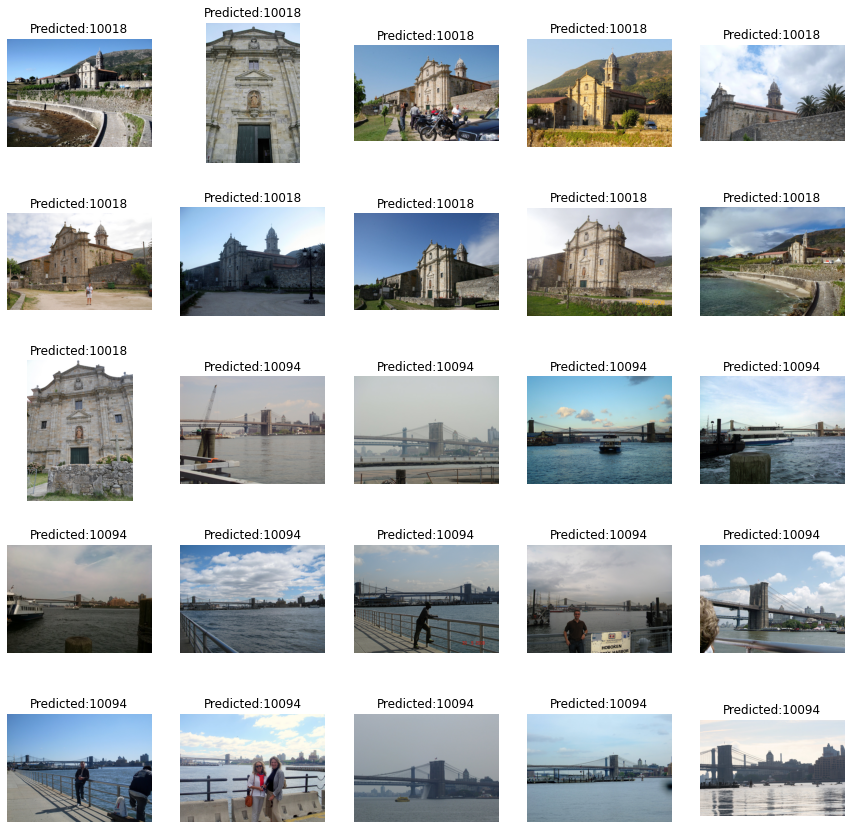

In [ ]:
import cv2

TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/Landmark Recognition/data/test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_set.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    indice = predicted_classes[i]
    predict_class = class_labels[indice]

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predict_class))    

plt.show()